In [ ]:

from datasets import load_dataset, DatasetDict
from transformers import ViTForImageClassification, ViTFeatureExtractor, DefaultDataCollator
from transformers import TrainingArguments, Trainer
import numpy as np

dataset = load_dataset("beans")

/home/clap/Documents/www/transformer/transformerenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Preprocess data using ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

def preprocess_data(examples):
    # Extract pixel values and normalize images
    images = [image for image in examples["image"]]
    inputs = feature_extractor(images=images, return_tensors="np")
    examples["pixel_values"] = inputs["pixel_values"]
    return examples

# Apply preprocessing to train and test splits
beans_data = dataset.map(preprocess_data, batched=True)

# Remove unused columns and set format for PyTorch
beans_data = beans_data.remove_columns(["image"])
beans_data.set_format("torch", columns=["pixel_values", "labels"])


/home/clap/Documents/www/transformer/transformerenv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=3,  # Beans dataset has 3 classes
    id2label={0: "angular_leaf_spot", 1: "bean_rust", 2: "healthy"},
    label2id={"angular_leaf_spot": 0, "bean_rust": 1, "healthy": 2},
     ignore_mismatched_sizes=True  
)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./vit-beans",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=10,
)

# Data collator for padding
data_collator = DefaultDataCollator()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/clap/Documents/www/transformer/transformerenv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define metrics
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=beans_data["train"],
    eval_dataset=beans_data["test"],
    tokenizer=feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation Results: {results}")

/tmp/ipykernel_67152/1869999488.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  3%|▎         | 10/325 [00:32<17:09,  3.27s/it]

{'loss': 0.9342, 'grad_norm': 6.896624565124512, 'learning_rate': 1.9384615384615386e-05, 'epoch': 0.15}


  6%|▌         | 20/325 [01:07<17:25,  3.43s/it]

{'loss': 0.566, 'grad_norm': 3.272181510925293, 'learning_rate': 1.876923076923077e-05, 'epoch': 0.31}


  9%|▉         | 30/325 [01:41<16:46,  3.41s/it]

{'loss': 0.4188, 'grad_norm': 3.938962459564209, 'learning_rate': 1.8153846153846155e-05, 'epoch': 0.46}


 12%|█▏        | 40/325 [02:17<17:02,  3.59s/it]

{'loss': 0.2992, 'grad_norm': 3.0603790283203125, 'learning_rate': 1.753846153846154e-05, 'epoch': 0.62}


 15%|█▌        | 50/325 [02:54<17:04,  3.72s/it]

{'loss': 0.1996, 'grad_norm': 3.955887794494629, 'learning_rate': 1.6923076923076924e-05, 'epoch': 0.77}


 18%|█▊        | 60/325 [03:32<16:51,  3.82s/it]

{'loss': 0.2072, 'grad_norm': 4.125977039337158, 'learning_rate': 1.630769230769231e-05, 'epoch': 0.92}


                                                
 20%|██        | 65/325 [03:59<14:30,  3.35s/it]

{'eval_loss': 0.15564733743667603, 'eval_accuracy': 0.9609375, 'eval_runtime': 9.8971, 'eval_samples_per_second': 12.933, 'eval_steps_per_second': 0.808, 'epoch': 1.0}


 22%|██▏       | 70/325 [04:19<19:11,  4.52s/it]

{'loss': 0.1297, 'grad_norm': 1.7715022563934326, 'learning_rate': 1.5692307692307693e-05, 'epoch': 1.08}


 25%|██▍       | 80/325 [04:57<15:28,  3.79s/it]

{'loss': 0.0805, 'grad_norm': 0.990084707736969, 'learning_rate': 1.5076923076923078e-05, 'epoch': 1.23}


 28%|██▊       | 90/325 [05:34<14:22,  3.67s/it]

{'loss': 0.0715, 'grad_norm': 1.3622729778289795, 'learning_rate': 1.4461538461538462e-05, 'epoch': 1.38}


 31%|███       | 100/325 [06:11<13:53,  3.70s/it]

{'loss': 0.0518, 'grad_norm': 4.71638822555542, 'learning_rate': 1.3846153846153847e-05, 'epoch': 1.54}


 34%|███▍      | 110/325 [06:48<13:20,  3.72s/it]

{'loss': 0.0414, 'grad_norm': 0.8148831725120544, 'learning_rate': 1.3230769230769231e-05, 'epoch': 1.69}


 37%|███▋      | 120/325 [07:25<12:39,  3.70s/it]

{'loss': 0.0595, 'grad_norm': 0.8283665180206299, 'learning_rate': 1.2615384615384616e-05, 'epoch': 1.85}


 40%|████      | 130/325 [08:01<10:40,  3.29s/it]

{'loss': 0.0397, 'grad_norm': 0.5951933264732361, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 40%|████      | 130/325 [08:11<10:40,  3.29s/it]

{'eval_loss': 0.05213681980967522, 'eval_accuracy': 0.9921875, 'eval_runtime': 9.8925, 'eval_samples_per_second': 12.939, 'eval_steps_per_second': 0.809, 'epoch': 2.0}


 43%|████▎     | 140/325 [08:49<11:51,  3.84s/it]

{'loss': 0.0162, 'grad_norm': 0.19598783552646637, 'learning_rate': 1.1384615384615385e-05, 'epoch': 2.15}


 46%|████▌     | 150/325 [09:26<10:53,  3.74s/it]

{'loss': 0.0077, 'grad_norm': 0.2841223478317261, 'learning_rate': 1.076923076923077e-05, 'epoch': 2.31}


 49%|████▉     | 160/325 [10:04<10:32,  3.83s/it]

{'loss': 0.0064, 'grad_norm': 0.10048086941242218, 'learning_rate': 1.0153846153846154e-05, 'epoch': 2.46}


 52%|█████▏    | 170/325 [10:43<09:57,  3.85s/it]

{'loss': 0.0066, 'grad_norm': 0.19374433159828186, 'learning_rate': 9.53846153846154e-06, 'epoch': 2.62}


 55%|█████▌    | 180/325 [11:21<09:19,  3.86s/it]

{'loss': 0.0346, 'grad_norm': 0.2922274172306061, 'learning_rate': 8.923076923076925e-06, 'epoch': 2.77}


 58%|█████▊    | 190/325 [11:59<08:32,  3.79s/it]

{'loss': 0.0076, 'grad_norm': 0.423173189163208, 'learning_rate': 8.307692307692309e-06, 'epoch': 2.92}


                                                 
 60%|██████    | 195/325 [12:27<07:25,  3.43s/it]

{'eval_loss': 0.05289075896143913, 'eval_accuracy': 0.9765625, 'eval_runtime': 10.3037, 'eval_samples_per_second': 12.423, 'eval_steps_per_second': 0.776, 'epoch': 3.0}


 62%|██████▏   | 200/325 [12:47<09:37,  4.62s/it]

{'loss': 0.0071, 'grad_norm': 0.04659608006477356, 'learning_rate': 7.692307692307694e-06, 'epoch': 3.08}


 65%|██████▍   | 210/325 [13:24<07:10,  3.75s/it]

{'loss': 0.0031, 'grad_norm': 0.0720573142170906, 'learning_rate': 7.076923076923078e-06, 'epoch': 3.23}


 68%|██████▊   | 220/325 [14:01<06:25,  3.68s/it]

{'loss': 0.0036, 'grad_norm': 0.09985021501779556, 'learning_rate': 6.461538461538463e-06, 'epoch': 3.38}


 71%|███████   | 230/325 [14:38<05:51,  3.70s/it]

{'loss': 0.0124, 'grad_norm': 0.0928570032119751, 'learning_rate': 5.846153846153847e-06, 'epoch': 3.54}


 74%|███████▍  | 240/325 [15:17<05:28,  3.87s/it]

{'loss': 0.0036, 'grad_norm': 0.1465173214673996, 'learning_rate': 5.230769230769232e-06, 'epoch': 3.69}


 77%|███████▋  | 250/325 [15:55<04:49,  3.86s/it]

{'loss': 0.0033, 'grad_norm': 0.08117151260375977, 'learning_rate': 4.615384615384616e-06, 'epoch': 3.85}


 80%|████████  | 260/325 [16:33<03:45,  3.47s/it]

{'loss': 0.0038, 'grad_norm': 0.18034523725509644, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 260/325 [16:43<03:45,  3.47s/it]

{'eval_loss': 0.043641068041324615, 'eval_accuracy': 0.984375, 'eval_runtime': 9.977, 'eval_samples_per_second': 12.829, 'eval_steps_per_second': 0.802, 'epoch': 4.0}


 83%|████████▎ | 270/325 [17:21<03:31,  3.85s/it]

{'loss': 0.0025, 'grad_norm': 0.04825446009635925, 'learning_rate': 3.384615384615385e-06, 'epoch': 4.15}


 86%|████████▌ | 280/325 [17:58<02:46,  3.70s/it]

{'loss': 0.0032, 'grad_norm': 0.08216671645641327, 'learning_rate': 2.7692307692307697e-06, 'epoch': 4.31}


 89%|████████▉ | 290/325 [18:36<02:11,  3.77s/it]

{'loss': 0.0027, 'grad_norm': 0.10355651378631592, 'learning_rate': 2.153846153846154e-06, 'epoch': 4.46}


 92%|█████████▏| 300/325 [19:13<01:33,  3.74s/it]

{'loss': 0.0028, 'grad_norm': 0.0827568843960762, 'learning_rate': 1.5384615384615387e-06, 'epoch': 4.62}


 95%|█████████▌| 310/325 [19:50<00:56,  3.74s/it]

{'loss': 0.0027, 'grad_norm': 0.05708907172083855, 'learning_rate': 9.230769230769232e-07, 'epoch': 4.77}


 98%|█████████▊| 320/325 [20:28<00:18,  3.73s/it]

{'loss': 0.002, 'grad_norm': 0.03751721233129501, 'learning_rate': 3.0769230769230774e-07, 'epoch': 4.92}


                                                 
100%|██████████| 325/325 [20:55<00:00,  3.31s/it]

{'eval_loss': 0.04260249808430672, 'eval_accuracy': 0.984375, 'eval_runtime': 9.818, 'eval_samples_per_second': 13.037, 'eval_steps_per_second': 0.815, 'epoch': 5.0}


100%|██████████| 325/325 [21:07<00:00,  3.90s/it]


{'train_runtime': 1267.8747, 'train_samples_per_second': 4.078, 'train_steps_per_second': 0.256, 'train_loss': 0.09945634882610578, 'epoch': 5.0}


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]

Evaluation Results: {'eval_loss': 0.05213681980967522, 'eval_accuracy': 0.9921875, 'eval_runtime': 9.1002, 'eval_samples_per_second': 14.066, 'eval_steps_per_second': 0.879, 'epoch': 5.0}


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


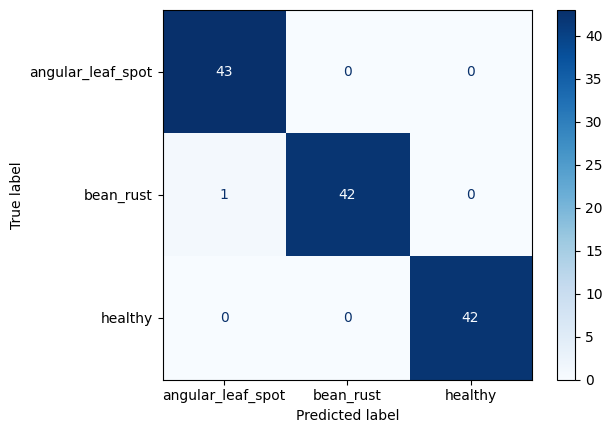

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Run predictions on the test set
predictions = trainer.predict(beans_data["test"])

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["angular_leaf_spot", "bean_rust", "healthy"])
disp.plot(cmap=plt.cm.Blues)
plt.show()